<a href="https://colab.research.google.com/github/Ahussain24/Animal-Classification/blob/main/animal_classifier_ipynb(git_hub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dataset from google drive

In [28]:
import os
import pathlib
import shutil

In [ ]:
#if you already have the dataset then dont need to run this cell
# you can delete this cell or comment it 
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d atowarhussain/animal-image-data
!unzip /content/animal-image-data.zip

Visualizing the dataset as it is 

In [30]:
dataset_dir = '/content/Animal/'

In [31]:
data_dir = pathlib.Path(dataset_dir)

In [32]:
img_classes = ['Horse','Cat','Pandas','Dog','Koala']

In [33]:
img_classes_count = {}
for c in  img_classes:
  img_classes_count[c] = len(list(data_dir.glob(c+'/*.*')))

print(img_classes_count)
  

{'Horse': 50, 'Cat': 50, 'Pandas': 50, 'Dog': 70, 'Koala': 52}


In [34]:
import matplotlib.pyplot as plt 

In [35]:
def bar(d) :

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(d.keys(),d.values())
  plt.show()


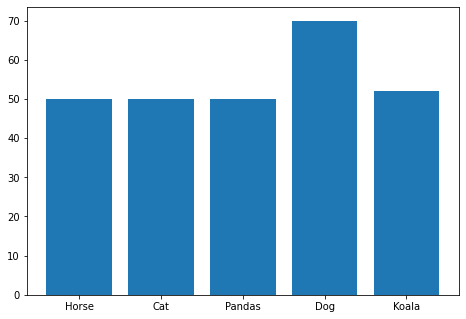

In [36]:
bar(img_classes_count)

Undersampling the majority class to handle imbalance in the dataset

In [37]:
minority_count = min(img_classes_count.values())

In [38]:
minority_count

50

**We will select only 300 images from each classes to reduce imbalance**

In [39]:
import random
import glob

In [40]:
#store all images in a single and its corresponding label in dict

img_file_dict = {}

for key in img_classes :
  img_file_dict[key] = []
  for imgfile in random.sample( list(data_dir.glob(key+'/*.*')) , minority_count ) :
    img_file_dict[key].append(str(imgfile))

In [41]:
img_label_dict = {}
for key in img_classes : 
  img_label_dict[key] = img_classes.index(key)

In [42]:
img_label_dict


{'Cat': 1, 'Dog': 3, 'Horse': 0, 'Koala': 4, 'Pandas': 2}

In [43]:
def plotImage(batch)  :

  imgs,labels = batch
  # create figure
  fig = plt.figure(figsize=(10, 7))

  rows = 2
  columns = 2
  s = 1

  for img,label in zip(imgs[:4],labels[:4]):

    fig.add_subplot(rows, columns, s)
    image = (img*255).astype(np.uint8)

    # showing image
    plt.imshow(image)
    plt.title(img_classes[np.argmax(label)])
    plt.axis('off')

    s+=1 

  plt.show()

In [44]:
import cv2
import numpy as np
from PIL import Image

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
IMG_SHAPE = 100

In [48]:
def load_images(img_file_dict,img_label_dict) :

  '''d --> dictionary containing path to image class
  return - x - > numpy array of rank 4 containg images ,y labels '''

  #store all our images in a list

  x = []
  y = []

  for key,vals in img_file_dict.items() :
    for loc in vals :

      img = cv2.imread(loc)
      resized_img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))
      x.append(resized_img)
      y.append(img_label_dict[key])
  
  #convert x into numpy array and make sure that each object in x is of same size
  x = np.asarray(x)
  y = np.asarray(y)

  return x,y


In [49]:
x,y = load_images(img_file_dict,img_label_dict)

In [50]:
x.shape

(250, 100, 100, 3)

In [51]:
y.shape

(250,)

In [52]:
def get_augmented_data(x,y,name=None) :
  '''generate batches of data by applying some transformation
  apply transformtion only on the training set'''

  if name != None :
    if name == 'train' :

      datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,channel_shift_range=0.3).flow(x,to_categorical(y))

    else :
      datagen = ImageDataGenerator(rescale=1./255).flow(x,to_categorical(y),shuffle=False)
  else :
    print('Must specify name as {} or {} or {}'.format('train','test','val'))
    return 

  return datagen

In [53]:
#split the data into train and test 
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

In [55]:
train_batch = get_augmented_data(x_train,y_train,'train')

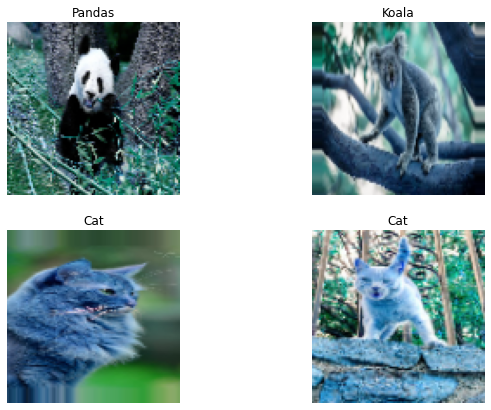

In [56]:
plotImage(next(train_batch))


**Building the model and training**

In [57]:
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import  L1,L2

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


In [60]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [74]:
fp = '/content/MODEL1/model1.epoch{epoch:02d}.hdf5'

In [75]:
#save the model with higest validation accuracy
mc = ModelCheckpoint(filepath=fp, monitor='accuracy',verbose=1,save_best_only=True, mode='max')

In [76]:
def train(model,cb=[mc],EPOCH=10) :

  '''compile and train the model and plot its loss and accuracy'''
  model.compile(optimizer='adam',loss=CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

  history = model.fit(train_batch,epochs=EPOCH,callbacks=cb)

  show_final_history(history)

  #print(f'\n{model.evaluate(x_test_scaled,to_categorical(y_test))}')




In [78]:
def show_final_history(history):
   
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[0].legend()
    ax[1].legend()

In [81]:
def cnn() :

  #define the input
  input = Input(shape=(IMG_SHAPE,IMG_SHAPE,3))

  conv1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv1')(input)
  conv2 = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv2')(conv1)
  pool1 = MaxPool2D()(conv2)


  conv3 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',name='conv3')(pool1)
  conv4 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',name='conv4')(conv3)
  pool2 = MaxPool2D()(conv4)
  
 
  conv5 = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',name='conv5')(pool2)
  pool3 = MaxPool2D()(conv5)

  conv6 = Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',name='conv8')(pool3)


  flat = Flatten()(conv6)

  outputs = Dense(units=5,activation='softmax',name='prediction')(flat)

  #building the model

  model = Model(input,outputs)

  return model

In [82]:
model = cnn()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 64)      1792      
                                                                 
 conv2 (Conv2D)              (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 50, 50, 128)       73856     
                                                                 
 conv4 (Conv2D)              (None, 50, 50, 128)       147584    
                                                           

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 1.6740 - accuracy: 0.1872
Epoch 00001: accuracy did not improve from 1.00000
6/6 [==============================] - 2s 134ms/step - loss: 1.6740 - accuracy: 0.1872
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 1.6106 - accuracy: 0.2460
Epoch 00002: accuracy did not improve from 1.00000
6/6 [==============================] - 1s 135ms/step - loss: 1.6106 - accuracy: 0.2460
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.2353
Epoch 00003: accuracy did not improve from 1.00000
6/6 [==============================] - 1s 140ms/step - loss: 1.5909 - accuracy: 0.2353
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 1.6174 - accuracy: 0.2460
Epoch 00004: accuracy did not improve from 1.00000
6/6 [==============================] - 1s 136ms/step - loss: 1.6174 - accuracy: 0.2460
Epoch 5/50
6/6 [==============================] - ETA: 0s - loss: 1.5846 - accur

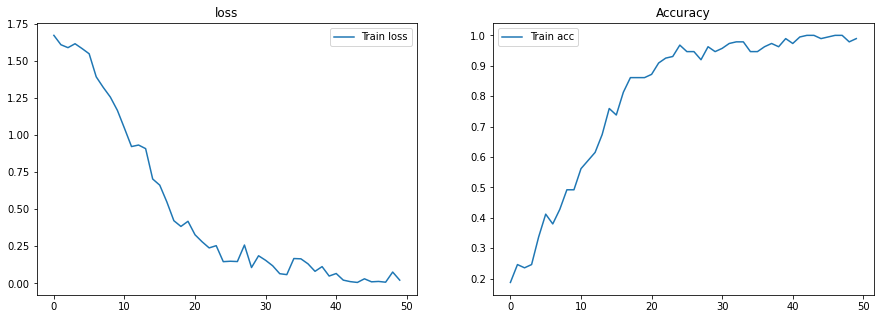

In [83]:
#!rm -rf /content/MODEL1
train(model,EPOCH=50)

In [84]:
test_batch = get_augmented_data(x_test,y_test,'test')

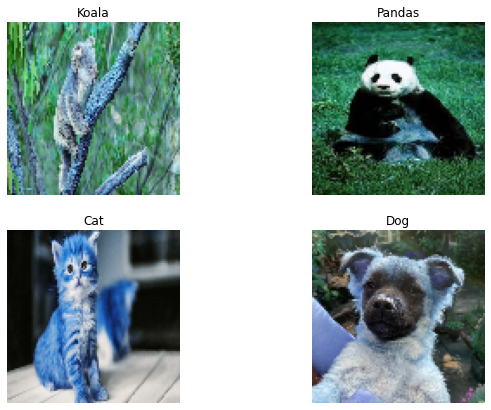

In [85]:
plotImage(next(test_batch))

In [86]:
from tensorflow.keras.models import load_model

In [87]:
best_model1 = load_model('/content/model1.hdf5')

In [88]:
best_model1.evaluate(test_batch)

2/2 [==============================] - 2s 1s/step - loss: 4.1670 - accuracy: 0.6032


[4.167025566101074, 0.60317462682724]

**As we can see that our model is overfiiting . To reduce it we can do following** .

1. Add More Data ( If possible )
2. Decrease the complexity of the model (remove some layers) 
3. BatchNormalization  
4. Dropout
5. Regularization 

***Evaluating model performance***

In [89]:
test_batch.reset()
pred = best_model1.predict(test_batch)

In [90]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report 

In [91]:
#let us create a confusion matrix to see how our model has acctually performed 
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [92]:
cm_plot_labels = img_classes
cm = confusion_matrix(y_true = y_test,y_pred = np.argmax(pred,axis = -1))

Confusion matrix, without normalization
[[8 1 0 1 0]
 [1 9 2 2 1]
 [1 1 9 0 1]
 [6 3 1 6 2]
 [0 0 0 2 6]]


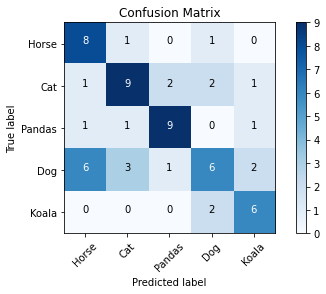

In [93]:
plot_confusion_matrix(cm = cm,classes=cm_plot_labels,title='Confusion Matrix')

In [94]:
classification_report(y_test,np.argmax(pred,axis=-1),target_names=img_classes).split('\n')

['              precision    recall  f1-score   support',
 '',
 '       Horse       0.50      0.80      0.62        10',
 '         Cat       0.64      0.60      0.62        15',
 '      Pandas       0.75      0.75      0.75        12',
 '         Dog       0.55      0.33      0.41        18',
 '       Koala       0.60      0.75      0.67         8',
 '',
 '    accuracy                           0.60        63',
 '   macro avg       0.61      0.65      0.61        63',
 'weighted avg       0.61      0.60      0.59        63',
 '']

**Make predictions from individual image**

In [95]:
from tensorflow.keras.utils import load_img,img_to_array


In [96]:
def make_prediction(p) :

  '''load the image and convert into numpy array of rank 4'''
  img = load_img(path=p,target_size=(IMG_SHAPE,IMG_SHAPE))
  img_array = np.asarray(img)
  img_array = np.expand_dims(img_array,axis=0)

  '''predict and display the image'''
  pred = model.predict(img_array)
  plt.imshow(img)
  plt.axis('off')
  plt.title(img_classes[np.argmax(pred)])


In [97]:
p = ''